In [1]:
import pandas as pd
                                        #데이터는 coinmarketcap 이라는 사이트에서 최근 1년치 비트 코인의 가격들(open, high, low, close, volume, marketcap)이 있는 데이터들을 csv로 다운받았습니다
file_path = '/Users/chj/Downloads/Bitcoin_2023. 12. 2.-2024. 12. 1._historical_data_coinmarketcap.csv'  # CSV 파일 경로
btc_data = pd.read_csv(file_path, sep = ';')  #열 이름을 출력한 결과를 보니, 모든 열 이름이 하나의 문자열로 묶여 있었다. 이는 CSV 파일이 잘못 구분되어 불러와졌을 가능성이 있으므로. ;(세미콜론)으로 구분된 파일이 쉼표(,)로 구분된 파일처럼 불러와져서 열 이름이 하나로 합쳐졌다. sep 인자를 사용해서 ; 로 구분하게한다. 

print(btc_data.head())          #각 열 마다 위의 5개의 데이터들을 출력. 데이터가 잘 불러와졌는지


                   timeOpen                 timeClose  \
0  2024-11-29T00:00:00.000Z  2024-11-29T23:59:59.999Z   
1  2024-11-28T00:00:00.000Z  2024-11-28T23:59:59.999Z   
2  2024-11-27T00:00:00.000Z  2024-11-27T23:59:59.999Z   
3  2024-11-26T00:00:00.000Z  2024-11-26T23:59:59.999Z   
4  2024-11-25T00:00:00.000Z  2024-11-25T23:59:59.999Z   

                   timeHigh                   timeLow  name          open  \
0  2024-11-29T15:21:00.000Z  2024-11-29T00:54:00.000Z  2781  95653.952594   
1  2024-11-28T01:01:00.000Z  2024-11-28T10:10:00.000Z  2781  95954.944882   
2  2024-11-27T20:31:00.000Z  2024-11-27T00:47:00.000Z  2781  91978.138582   
3  2024-11-26T06:28:00.000Z  2024-11-26T20:40:00.000Z  2781  93087.279992   
4  2024-11-25T09:23:00.000Z  2024-11-25T22:40:00.000Z  2781  98033.442700   

           high           low         close        volume     marketCap  \
0  98693.168167  95407.886372  97461.523713  5.496868e+10  1.928821e+12   
1  96650.203768  94677.354296  95652.465159 

In [3]:
# 필요한 특징,feature 선택한다. 다음날의 마지막 비트코인 가격을 예측하는 것이기 때문에 1년치 데이터들중에 가격들(open ,high ,low ,close ,volume(거래량), marketCap(시가총액 = 현재 비트코인 가격 * 유통중인 비트코인 수))만 추출한다. 시가총액은 비트코인의 시장 내 상대적인 규모를 나타내며, 다른 암호화폐와 비교할 때 안정성이나 성숙도를 판단하는 데 유용합니다. 시가총액이 크면 시장이 상대적으로 안정적일 가능성이 높고, 시장 내에서 비트코인의 영향력이 크다는 의미 
btc_data = btc_data[['open', 'high', 'low', 'close', 'volume', 'marketCap']] 

# 레이블(target) 생성 (target = 다음 날의 close 값)..shift(1)은 close값들(열)을 한 칸 내려가게 해서 전날 나머지 값들이 다음 날의 close값을 target으로 잡게 설정한다. 그래야 다음날의 close값을 예측하는 것이기 떄문에
btc_data['Target'] = btc_data['close'].shift(1)

# 결측값 제거가 무조건 필요하다. 왜냐하면, shift(1)로 target값 열, 즉 close값 행들이 한칸 아래로 내려 갔으므로 첫번째 close값은 결측값이 된다. 결측값이 모델 학습을 방해하므로 없애줍니다. 그리고 텐서플로우 같은 딥러닝 라이브러리는 입력 데이터에 결측값이 있으면 에러가 생김. 
btc_data = btc_data.dropna()


# 특성과 레이블 분리......특성(X): open, high, low, volume, marketCap 특성의 값들을 분리시켜기 위해 values로 설정.....레이블(y): Target 컬럼을 종속 변수로 설정하여 예측하려는 값(다음 날의 close값)을 지정합니다.
X = btc_data[['open', 'high', 'low', 'volume', 'marketCap']].values              #.values는 Pandas 데이터프레임이나 시리즈 객체에서 데이터를 NumPy 배열로 변환하는 데 사용된다. 텐서플로우나 다른 머신러닝 라이브러리에서 데이터를 입력받을 때 일반적으로 NumPy 배열 형식을 요구한다. 그래서 .values로 numpy 배열로 값들을 바꿔줍니다 
y = btc_data['Target'].values


In [5]:
#데이터 분할 및 정규화...이 코드는 데이터 분할 및 정규화 과정에 관한 것으로, 머신러닝 모델을 학습시키기 위한 준비 작업. 각 단계는 데이터를 훈련, 검증, 테스트 세트로 나누고, 데이터를 정규화하여 모델의 성능을 최적화한다.
from sklearn.model_selection import train_test_split   #데이터 분할...train_test_split 이라는 함수는 데이터를 랜덤하게 trainset과 testset으로 나누어준다.
from sklearn.preprocessing import MinMaxScaler         #데이터 정규화를 도와주는 클래스

# 데이터 분할 ...   
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state = 0)   # X를 입력값으로 y를 타겟 값으로 나눔. 전체 데이터의 70%를 학습데이터(X_train, y_train) 와 30%는 테스트/검증 데이터(X_temp, y_temp)로 나눈다.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state = 0) # trainset중 70% 와 testset30%중에서 반은 검증set, 나머지 반은 testset. trainset은 모델의 가중치를 업데이트하는 데 사용되며, 검증 set은 가중치 업데이트 과정에서 모델 성능을 체크하는 데 사용됩니다. 검증 set은 trainset에 포함되지 않기 때문에 모델의 실제 성능을 평가하는 데 중요한 역할을 한다. 모델의 성능을 최적화하기 위해 하이퍼파라미터(ex. 학습률, 네트워크 층 수, 배치 크기 등)를 조정할 때, 검증 세트를 이용하여 다양한 하이퍼파라미터를 실험하고 그 결과를 평가. 이렇게 해서 검증set 에서 좋은 성과를 보이는 하이퍼파라미터를 선택. 또 과적합 방지 

                                          # 정규화.. 데이터의 값을 일정한 범위로 변환하여 모델이 학습할 때 특정 특성에 지나치게 의존하지 않도록 만드는 과정. 특성들은 값의 범위가 다를 수 있는데, 이를 동일한 범위로 조정하는 것이 중요
scaler = MinMaxScaler()                   # MinMaxScaler(). 이 클래스는 각 특성의 값을 0과 1사이로 변환
X_train = scaler.fit_transform(X_train)   # fit_transform 메서드는 훈련 데이터에 대한 정규화를 학습하고 적용하는데 사용됩니다
X_val = scaler.transform(X_val)           # transform 메서드는 이미 학습된 정규화를 검증 세트와 테스트 세트에 적용합니다.
X_test = scaler.transform(X_test)         

#검증 세트와 테스트 세트는 모델을 학습할 때 사용되지 않기 때문에, 훈련 세트에서 계산된 스케일링 정보를 그대로 적용해야 합니다.
# 타겟도 정규화
y_scaler = MinMaxScaler()  #똑같이 0과1 사이의 값으로 변환해주는 클래스 호출하고
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))     # reshape(-1, 1)을 한 이유는 y_train, y_val, y_test는 기본적으로 1D(스칼라) 배열입니다. MinMaxScaler는 2D(벡터) 배열을 요구하므로, 1열 벡터 형태로 변환하는 작업을 합니다.
y_val = y_scaler.transform(y_val.reshape(-1, 1))            # y_scaler.fit_transform: 훈련 데이터에 대해서는 fit_transform을 사용해 정규화를 수행하고, 검증 데이터와 테스트 데이터에 대해서는 이미 학습된 scaler를 사용해 transform만 수행합니다
y_test = y_scaler.transform(y_test.reshape(-1, 1))


In [7]:
import tensorflow as tf

#모델 생성하기.. dense layer 알고리즘
model = tf.keras.Sequential([                     #Sequential 모델로 순차적인 층을 쌓는다.
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),     #첫번쨰 은닉층으로 128개의 뉴런을 그리고 활성화함수로 ReLU를 사용한다. 
    tf.keras.layers.Dropout(0.3),                                                       # Dropout : 30%의 뉴런(노드)를 무작위로 dropout 시킨다. 과적합 방지를 위해 
    tf.keras.layers.Dense(64, activation='relu'),                                       #두번쨰 은닉층(hidden layer)으로 64개의 뉴런, 활성화함수 ReLU 
    tf.keras.layers.Dropout(0.3),                                                        #Dropout
    tf.keras.layers.Dense(32, activation='relu'),                                        #세번째 은닉층 : 노드 32개, 활성화함수 ReLU
    tf.keras.layers.Dense(1)  # 연속형 출력                         #출력층,,회귀문제(연속적인 값을 예측)이기 떄문에 예측값이 그대로 나와야하기 떄문에 활성화함수는 없다.별도의 비선형 변환을 추가하지 않는다.선형 출력.출력값을 그대로 나오게한다      활성화함수로 sigmoid를 사용하면 출력값이 [0,1]로 제한된다.
])
# 층을 더 쌓았었는데 오히려 test loss가 안좋게 나와서 줄였습니다


model.compile(optimizer='adam', loss='mse', metrics=['mae'])          #모델 컴파일 할때는 최적화함수(optimizer)를 Adam(학습률을 조정해주는, 경사하강법과 같은 부류의 알고리즘)으로 설정하고 손실함수(loss function)은 MSE(Mean squared Error, 평균 제곱 오차: 회귀 모델의 성능을 평가하는데 사용하는 대표적인 손실 함수. 모델 예측한 값과 실제 값 차이를 제곱하여 평균을 구한 값)를 사용한다. 예측 오차의 절대값 평균을 계산한다



2024-12-02 22:42:24.870812: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# 위에서 만든 모델로 훈련하기 model.fit
history = model.fit(                        # 딥러닝 모델을 훈련시킨다. model.fit()메서드는 주어진 데이터와 설정을 기반으로 모델을 학습
    X_train, y_train,                        # X_train은 입력 데이터(특징),,y_train은 target 데이터(레이블),실제 값들
    validation_data=(X_val, y_val),          # (validation_data) = 검증 데이터 로 학습과정에서 모델 성능을 평가한다.
    epochs=300,                              # 전체 데이터셋으로 300번을 반복하여 학습하게 하고 , 배치 크기는 32로 설정합니다.
    batch_size=32                            # 데이터를 전체 데이터에서 32개씩 나누어서 처리한다.   배치학습 - 메모리 사용량 줄이고 효율적인 학습을 돕는다
)


Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.2148 - mae: 0.4138 - val_loss: 0.1425 - val_mae: 0.2972
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0964 - mae: 0.2633 - val_loss: 0.0348 - val_mae: 0.1530
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0302 - mae: 0.1399 - val_loss: 0.0178 - val_mae: 0.1151
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0238 - mae: 0.1297 - val_loss: 0.0100 - val_mae: 0.0781
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0143 - mae: 0.0953 - val_loss: 0.0111 - val_mae: 0.0876
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141 - mae: 0.0943 - val_loss: 0.0092 - val_mae: 0.0798
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0108 - mae: 0.0768 - val_loss: 0.0063 - val_mae: 0.0660
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0100 - mae: 0.0759 - val_loss: 0.0063 - val_mae: 0.0663
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0090 - mae: 

In [11]:
# test set으로 모델 평가하기
test_loss, test_mae = model.evaluate(X_test, y_test)              # 위에서 만든 모델을 test data(X_test, y_test) 로 평가한다. model.evaluate() 는 모델이 테스트 데이터에서의 성능을 평가하는데 사용된다. 그리고 출력값들을 test_loss:모델이 예측한 값과 실제 값 간의 손실값, test_mae: 테스트 데이터에서 계산된 평가 지표포 평균 절대 오차를 말한다. 
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")           #test_loss 는 테스트 데이터에 대해 계산된 손실 값이다. loss function은 위에서 설정한 평균 제곱 오차(mse)이다. test_mae 는 모델이 테스트 데이터에서 얼마나 정확히 예측했는지 측정한다. MAE는 예측값과 실제 값 사이의 차이들의 평균의 절대값을 나타낸다. 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - mae: 0.0272
Test Loss: 0.0013239339459687471, Test MAE: 0.02771766670048237


/

/

<ChatGPT를 사용한 부분에 대한 설명과 해당 프롬프트 및 그 결과>



필요한 feature들을 선택해서 btc_data에 넣으려하는데 오류가 계속 나서 보니 csv파일에서 ;로 열들이 구분되어 있어서 오류가 났었다.  

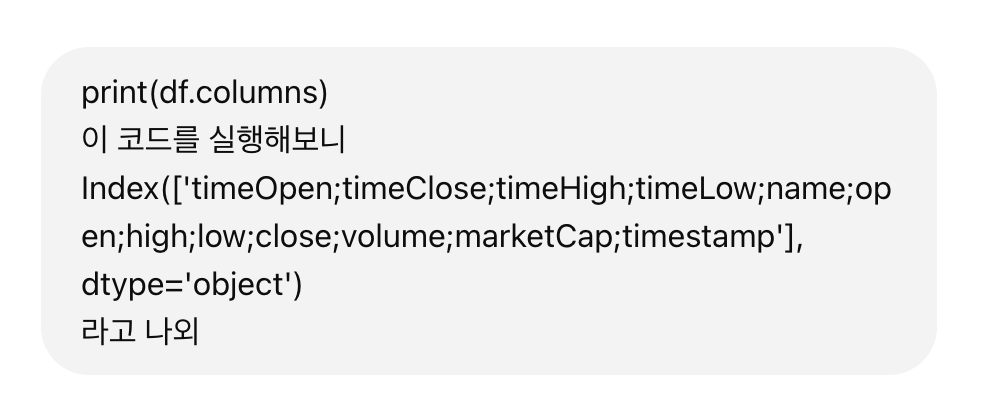

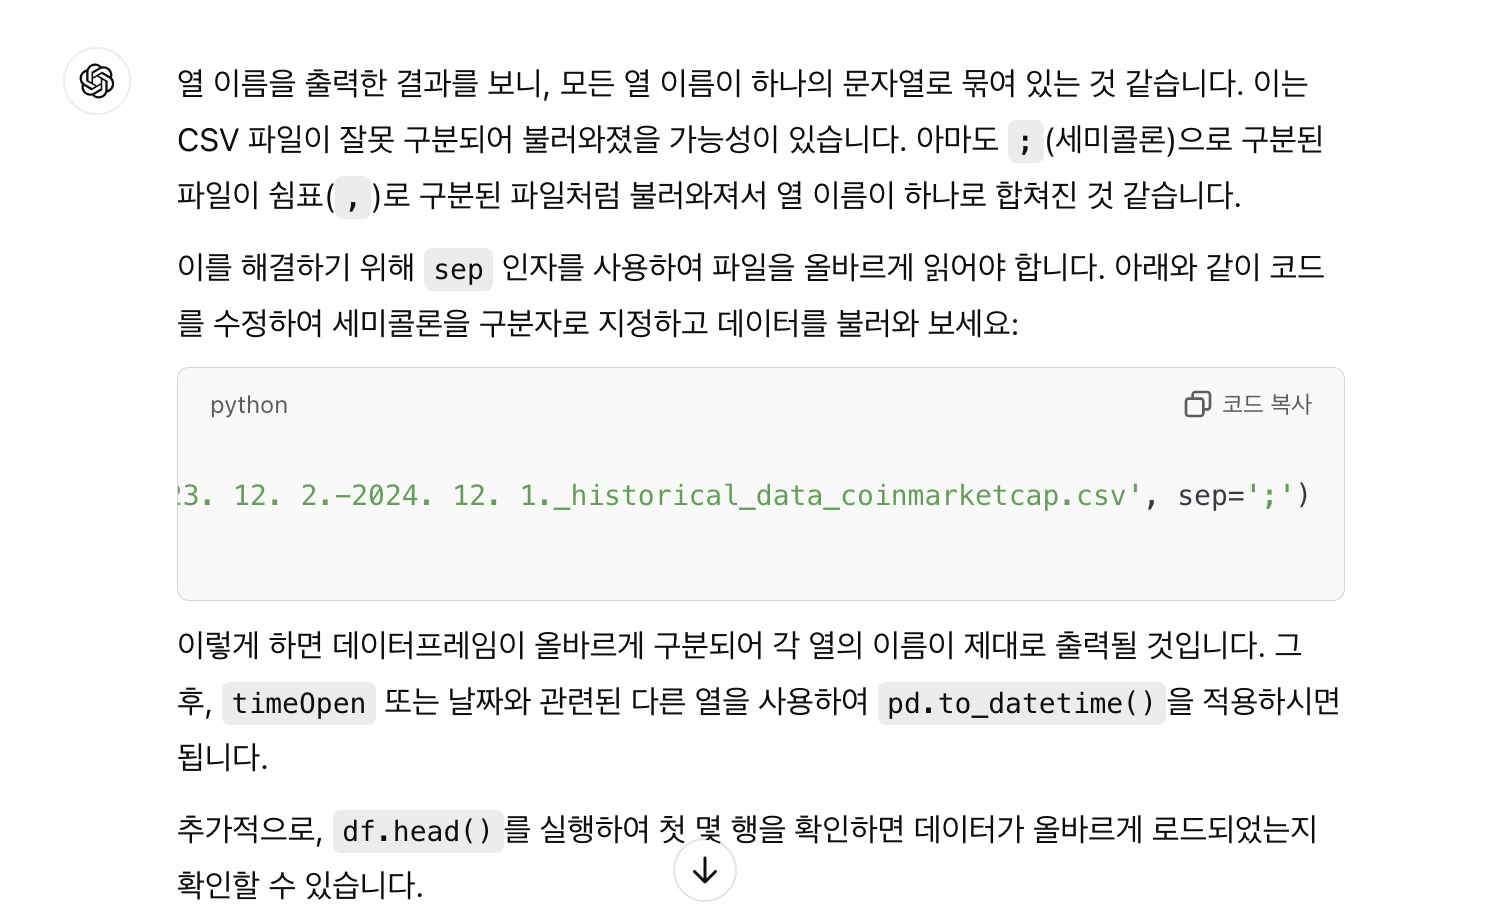

다음날의 close값을 타겟값으로 잡고 싶은데 코드를 어떻게 짜야할지 의문이 들었다.

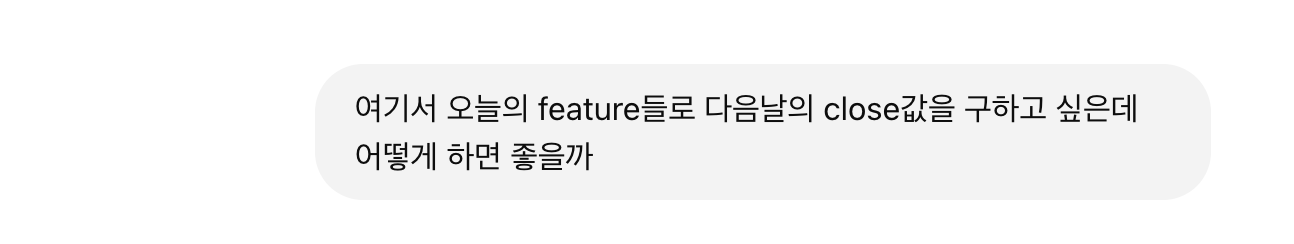

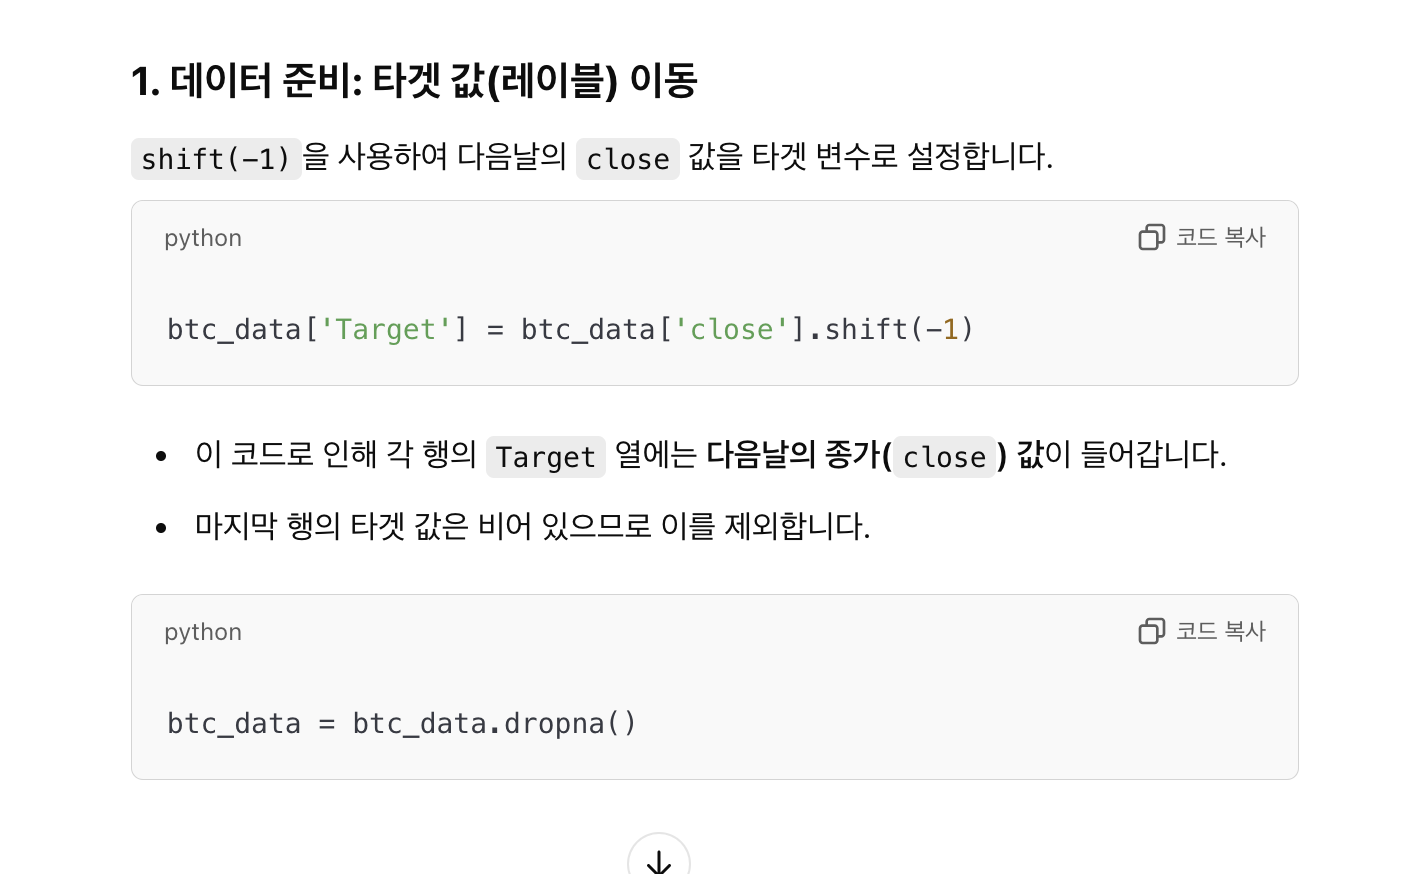

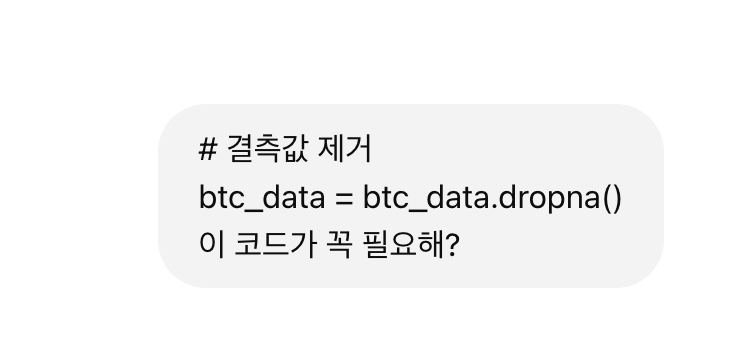

feature 값들이 open,high,low,close 값은 범위가 비슷한데 volume, marketcap 값의 범위가 너무 달라서 해결방법을 물어봤다.

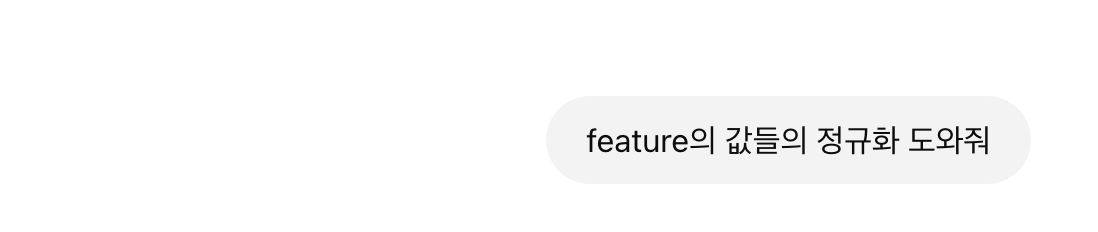

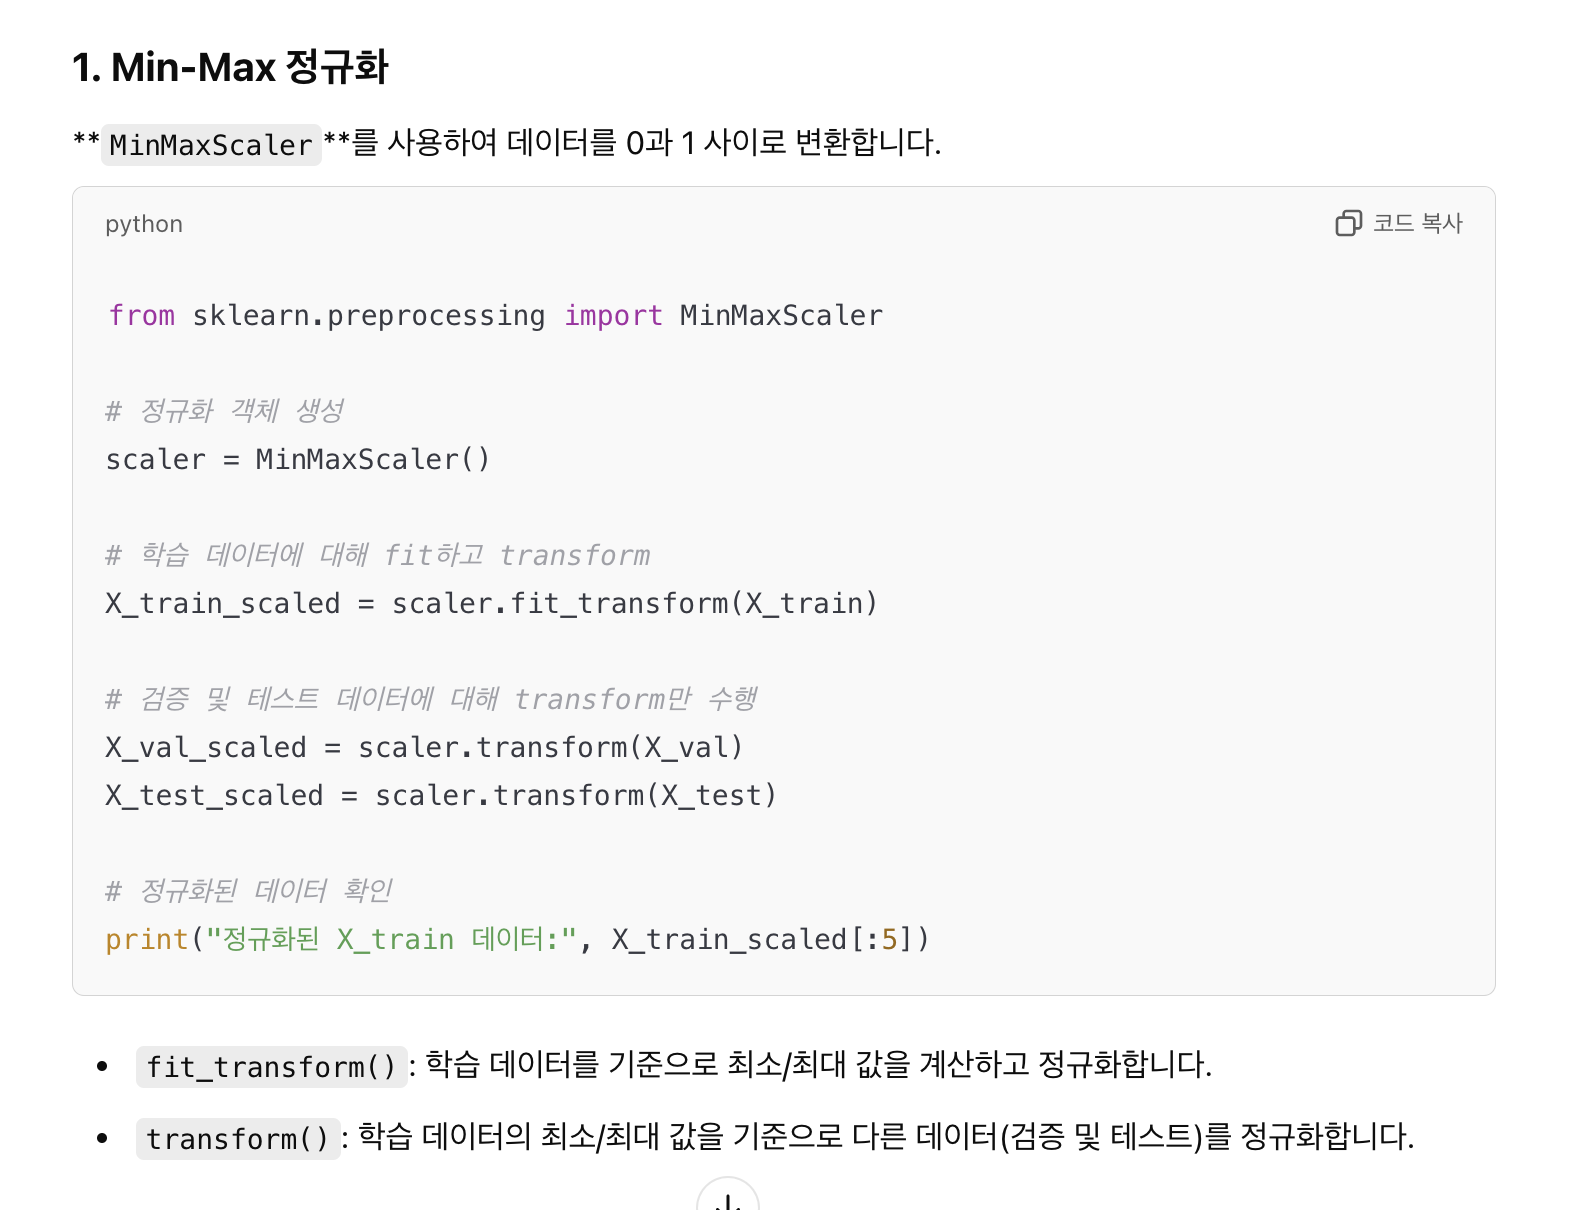